In [38]:
# --------------------------------------------
# 1. Install Gradio (only if needed)
# --------------------------------------------
!pip install -q gradio

# --------------------------------------------
# 2. Import Libraries
# --------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import files
import zipfile
import os

import gradio as gr
from PIL import Image


In [39]:
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]
extract_path = "dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

Saving modified-dataset.zip to modified-dataset (2).zip


['train', 'val', 'test']

In [40]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32

train_path = "dataset/train"
val_path   = "dataset/val"
test_path  = "dataset/test"

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, shuffle=True, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path, shuffle=True, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, shuffle=False, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [42]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

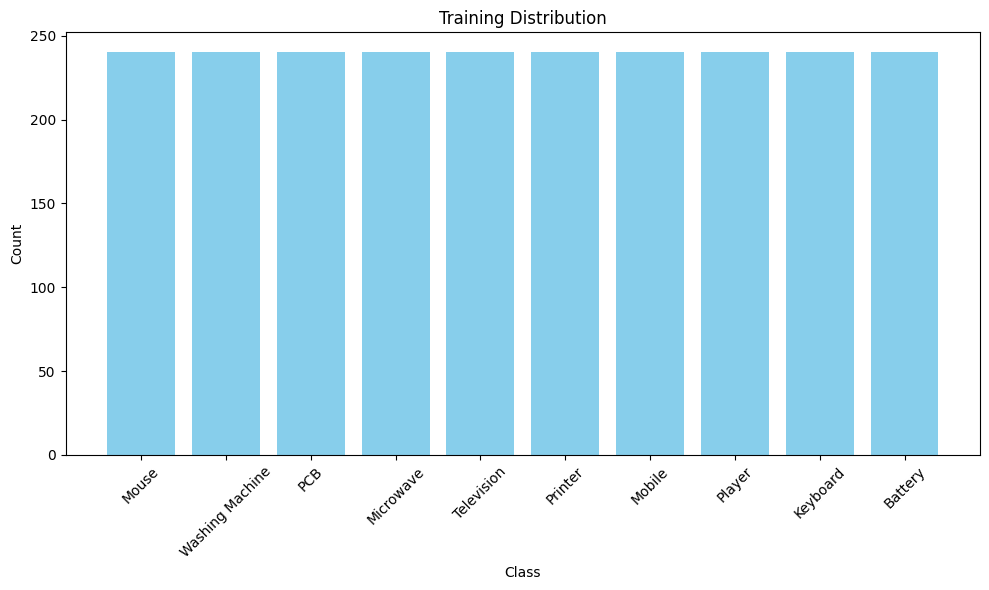

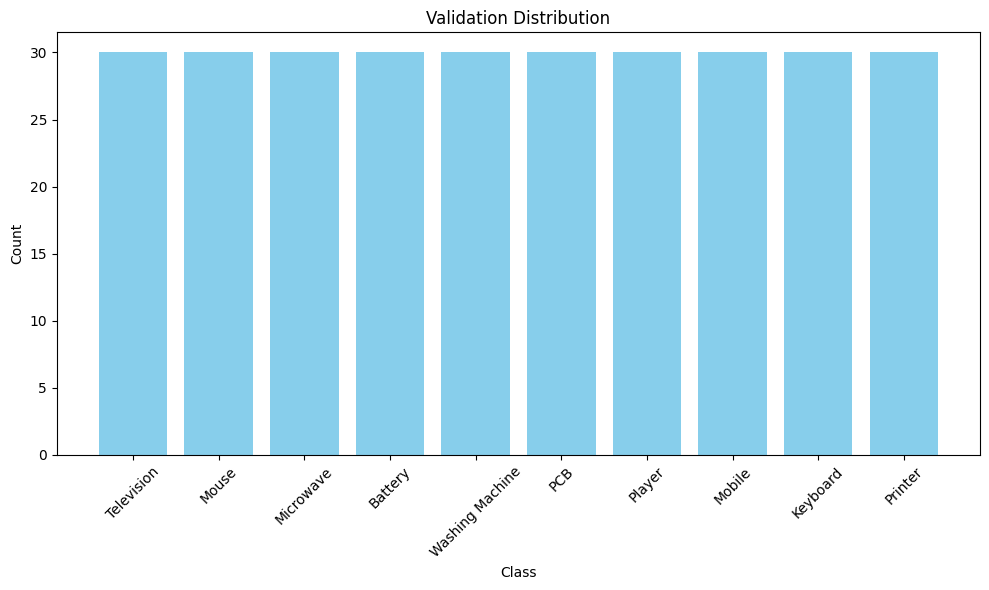

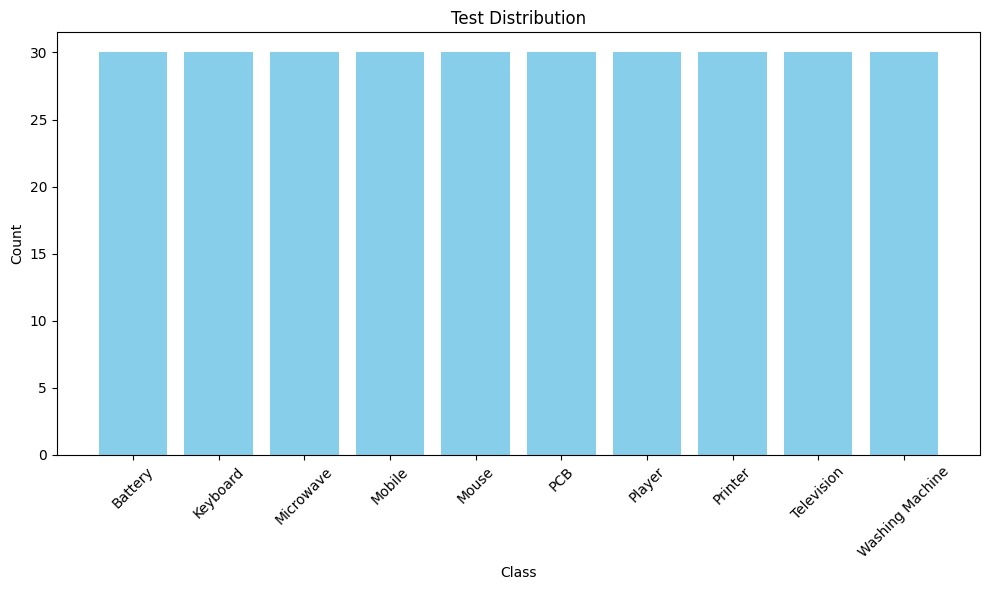

In [43]:
def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_ds, "Training Distribution")
plot_class_distribution(val_ds, "Validation Distribution")
plot_class_distribution(test_ds, "Test Distribution")

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [45]:
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,)
)
base_model.trainable = False  # Freeze initially

inputs = layers.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [46]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_fn,
    metrics=['accuracy']
)

In [47]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

In [48]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [49]:
history_initial = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 452ms/step - accuracy: 0.4756 - loss: 1.8130 - val_accuracy: 0.9567 - val_loss: 0.7313 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.8632 - loss: 0.9156 - val_accuracy: 0.9700 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.8975 - loss: 0.8331 - val_accuracy: 0.9733 - val_loss: 0.6360 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - accuracy: 0.9084 - loss: 0.7972 - val_accuracy: 0.9700 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.9114 - loss: 0.7867 - val_accuracy: 0.9733 - val_loss: 0.6220 - learning_rate: 0.0010
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 328ms/step - accuracy: 0.9238 - loss: 0.7679 - val_accuracy: 0.9667 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - accuracy: 0.9149 - loss: 0.

In [50]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6690 - loss: 1.3821 - val_accuracy: 0.9400 - val_loss: 0.7849 - learning_rate: 1.0000e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7934 - loss: 1.0990 - val_accuracy: 0.9567 - val_loss: 0.7192 - learning_rate: 1.0000e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8418 - loss: 0.9476 - val_accuracy: 0.9633 - val_loss: 0.6852 - learning_rate: 1.0000e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8762 - loss: 0.8663 - val_accuracy: 0.9633 - val_loss: 0.6719 - learning_rate: 1.0000e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8997 - loss: 0.8373 - val_accuracy: 0.9667 - val_loss: 0.6633 - learning_rate: 1.0000e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8928 - loss: 0.8036 - val_accuracy: 0.9667 - val_loss: 0.6530 - learning_rate: 1.0000e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9212 - los

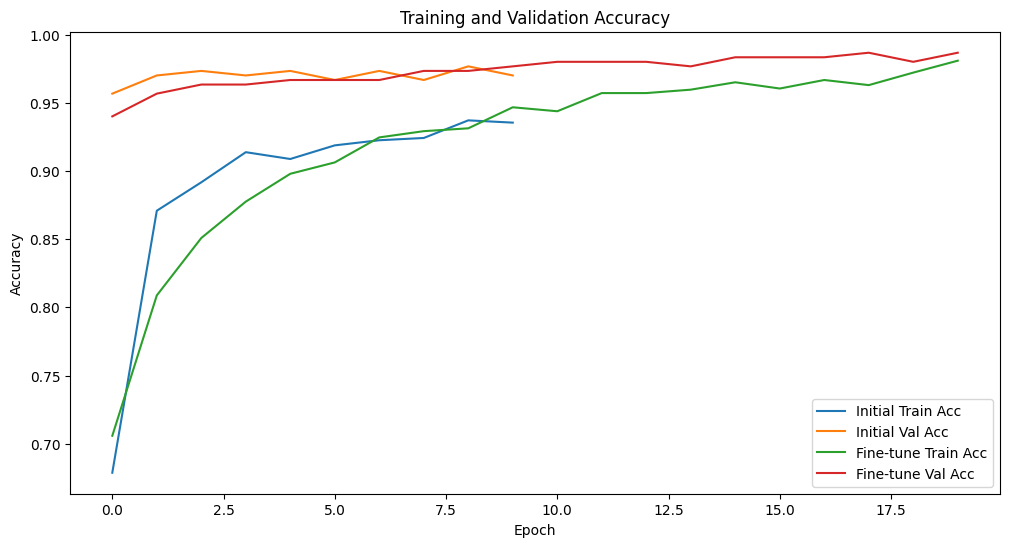

In [51]:
def plot_history(histories, labels):
    plt.figure(figsize=(12, 6))

    for h, label in zip(histories, labels):
        plt.plot(h.history['accuracy'], label=f'{label} Train Acc')
        plt.plot(h.history['val_accuracy'], label=f'{label} Val Acc')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history([history_initial, history_fine], ['Initial', 'Fine-tune'])

In [52]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.9734 - loss: 0.6145
Test Accuracy: 0.9767, Test Loss: 0.6133


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 847ms/step
[[28  0  0  0  0  1  0  0  0  1]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  1  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  1 29  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  1 29  0  0]
 [ 0  0  1  0  0  0  0  0 29  0]
 [ 1  0  0  0  0  0  0  0  0 29]]
                 precision    recall  f1-score   support

        Battery       0.97      0.93      0.95        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.97      1.00      0.98        30
         Mobile       1.00      0.97      0.98        30
          Mouse       0.97      1.00      0.98        30
            PCB       0.97      0.97      0.97        30
         Player       0.97      1.00      0.98        30
        Printer       1.00      0.97      0.98        30
     Television       0.97      0.97      0.97        30
Washing Machine       0.97      0.97      0.97        30

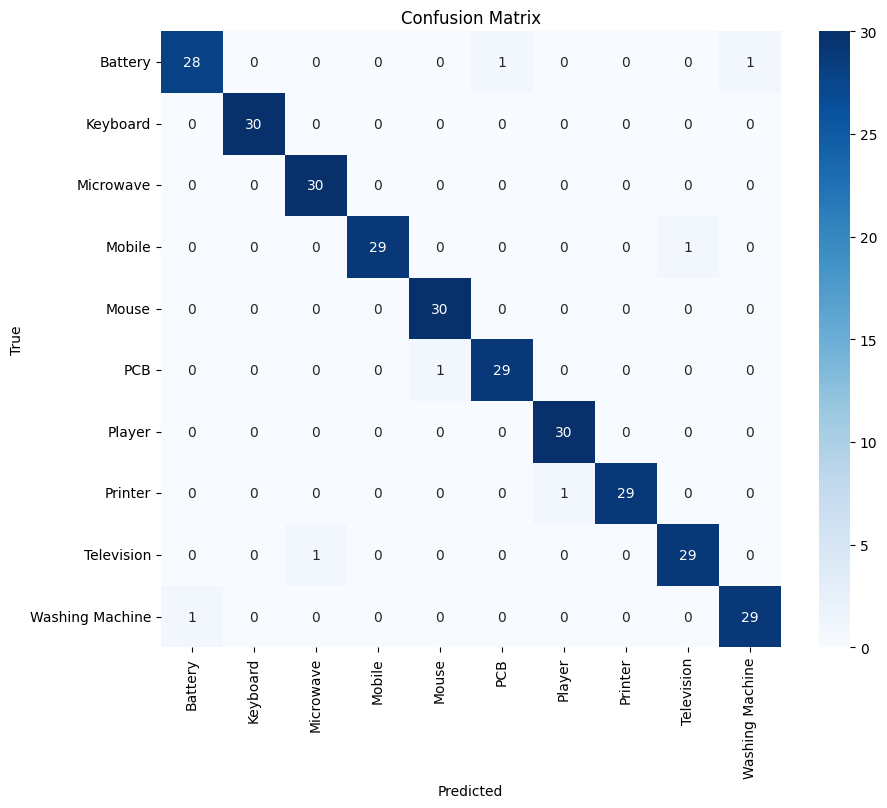

In [53]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print(confusion_matrix(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [54]:
model.save('EfficientV2S_Classifier.keras')

In [55]:
def classify_image(img):
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img, dtype=np.float32)

    # ✅ The critical fix: use EfficientNetV2 preprocessing
    img_array = preprocess_input(img_array)

    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]
    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"


iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="E-Waste Classifier",
    description="Upload an image of an electronic item to classify."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://76718c52d828269bea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
